In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 02/05/2023

    Code description :
    __________________
    Compare differents optimisation algorithms for inverting the interferometric
    lensless endoscopy model in terms of quality of reconstruction, as well as speed.
    PyUnLocBox, SPGL1 and PyProximal toolboxes are used here.
    The observation model is the fast autocorrelation-based one.
    The object of interest is in 2D.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers
import spgl1
import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from IHT import IHT
from functions import corr_circ2
from graphics import  show_rec2D

In [2]:
"Parameters"
N = 64 # image sidelength
K = 5 # sparsity
Q = 110 # Number of cores
M = 400 # Number of observations y
maxit=500 # Maximum number of iterations 

"Create the sample space"
pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
f = np.zeros((N,N))
"Define the sparse object"
indices = np.random.permutation(np.arange(N**2))[:K] 
indices_x = indices//N
indices_y = indices%N
f[indices_y[:-1], indices_x[:-1]] = np.random.randn(K-1)
f[indices_y[-1], indices_x[-1]] = -np.sum(f)

f_flat = f.reshape(-1)

"Fermat spiral"
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')
pos_inds = np.round((pos_sources+diam_endo/2)*N/diam_endo).astype(int) # convert sources positions to indices in R^(NxN) space.

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_inds[0,:], pos_inds[0,:]).astype(int)
Om_y = np.subtract.outer(pos_inds[1,:], pos_inds[1,:]).astype(int)

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core
B = np.zeros((N,N,M), dtype=complex)
B[pos_inds[0], pos_inds[1],:] = a_ij.T
B2 = corr_circ2(B.conj())

"Observation model"
g = lambda Xin: np.real(np.tensordot(T(Xin), B2)) /np.sqrt(M)
gt = lambda Xin: np.real(T_star( np.conj(B2@Xin) )) /np.sqrt(M)
nu_rop = eval_nu(np.random.randn(N,N), g, gt, nb_iter=50)*1.01
y = g(f) # The M real observations

### Gradient Descent

Solve
\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 
\end{equation*}

using Gradient Descent algorithm:

\begin{equation*}
    \boldsymbol x^{(k+1)} = \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) 
\end{equation*}

with PyUnLocBox toolbox.

INFO: Dummy objective function added.
Solution found after 500 iterations:
    objective function f(sol) = 5.570367e-01
    stopping criterion: MAXIT


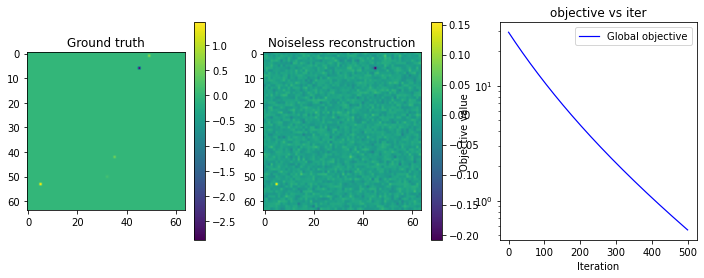

SNR: 0.41 dB


In [3]:
"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop)

x0 = np.zeros(f.shape)
solver = solvers.gradient_descent(step=1/nu_rop)
ret = solvers.solve([f2], x0, solver, rtol=1e-7, maxit=maxit, verbosity='LOW')
obj_GD = np.array(ret['objective'])[:,0]

show_rec2D(f, ret['sol'], objective=obj_GD)

### Forward-Backward

Solve
\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \boldsymbol u \rVert_1
\end{equation*}

using Forward-Backward algorithm:

\begin{equation*}
    \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right)
\end{equation*}

with PyUnLocBox toolbox.

Solution found after 500 iterations:
    objective function f(sol) = 3.130669e+00
    stopping criterion: MAXIT


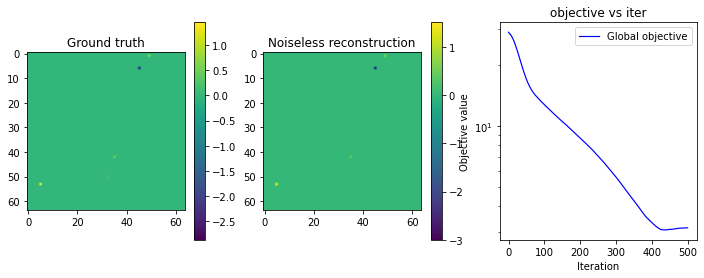

SNR: 25.59 dB


In [4]:
"Solver parameters"
solver = solvers.forward_backward(step=0.5/nu_rop )

"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop)
lamb = 0.5
f1 = functions.norm_l1(lambda_=lamb)

ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=maxit, verbosity='LOW')

show_rec2D(f, ret2['sol'], np.sum(np.array(ret2['objective']),1))

Solution found after 300 iterations:
    objective function f(sol) = 5.855846e+00
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 1.428789e-02
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 9.604542e-04
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 1.515317e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.725407e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.723762e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.704423e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.692067e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.697538e-03
    stopping criterion

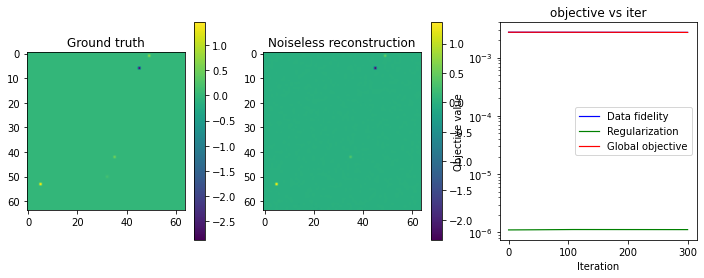

SNR: 14.00 dB


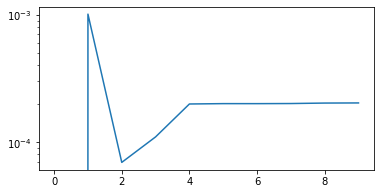

In [5]:
"Solver parameters"
solver = solvers.forward_backward(step=1/(2*nu_rop) )
maxit=300
SNR_target = 70
epsilon = np.linalg.norm(f)*10**(-SNR_target/20)
bigit = 10

"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop, tight=True)

f_hat = np.zeros(f.shape)
lambs = np.zeros(bigit)
objectives = np.zeros(bigit)
lamb = 1
i=1
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat
    f1 = functions.norm_l1(lambda_=lamb)
    ret = solvers.solve([f1, f2], x0, solver, rtol=1e-9, maxit=maxit) #, verbosity='NONE')
    f_hat = ret['sol']
    lamb *= epsilon/np.linalg.norm(g(ret['sol'])-y)
    lambs[i] = lamb
    objectives[i] = np.sum(np.array(ret['objective'])[-1,:])
    i+=1

show_rec2D(f, ret['sol'], objective=ret['objective'], show_Fourier=False)

plt.figure(figsize=(6,3))
plt.plot(lambs, linewidth=1.5)
plt.yscale('log')
plt.show()

## Iterative Hard Thresholding (IHT)

\begin{align*}
    x^{(k+1)} &= \mathcal{H}_K \left( x^{(k)} + \gamma \boldsymbol{\Phi}^* 
    (\boldsymbol y - \boldsymbol\Phi x^{(k)}) \right) \\
    &= \mathcal{H}_K \left( x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right).
\end{align*}

Hence, $\mathcal{H}_K$ plays the role of the proximal operator for the $\ell_0$ norm.

MAXIT reached: 100 iterations


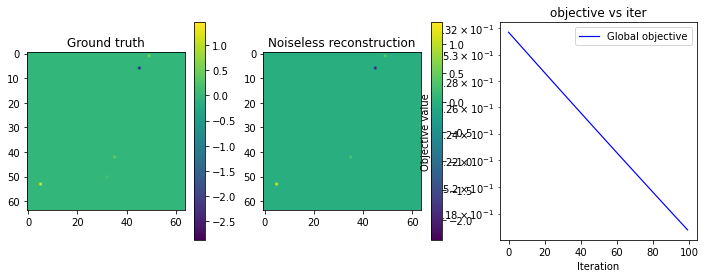

SNR: 14.42 dB


In [6]:
xn, diffs, obj_IHT = IHT(x0, y, s=K, A=g, At=gt, nu=0.5/nu_rop, lamb=lamb, maxit=100, mode='L2', verbosity='low')

show_rec2D(f, xn, objective=obj_IHT)

## SPGL1

The SNR is defined as:
\begin{equation*}
    SNR = 20 \log \left( \frac{\lVert f \rVert_2}{\lVert f - \hat{f} \rVert_2} \right)
\end{equation*}

We thus target an error of:
\begin{equation*}
    \lVert f - \hat{f} \rVert_2 = \lVert f \rVert_2 ~10^{SNR/20}
\end{equation*}

Where the SNR value can be changed.

Solves 3 problems:

**Lasso problem**
\begin{equation*}
    \min_x~\frac{1}{2} \lVert Ax - b \lVert_2^2 \text{ s.t. } \lVert x \rVert_1 \le \tau
\end{equation*}

**Basis Pursuit DeNoise (BPDN)**
\begin{equation*}
    \min_x~ \lVert x \rVert_1 \text{ s.t. } \lVert Ax - b \lVert_2 \le \sigma
\end{equation*}

**Basis Pursuit (BP)**
\begin{equation*}
    \min_x~ \lVert x \rVert_1 \text{ s.t. } Ax = b 
\end{equation*}

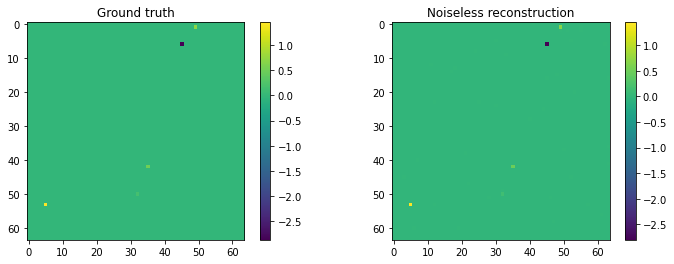

SNR: 30.22 dB


In [7]:
SNR_target = 100
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)[0]
bpdnalg = lambda A, b, sigma: spgl1.spg_bpdn(A, b, sigma, opt_tol=opt_tol)[0]


A_corr2 = Autocorr_model2(B2)
y_corr = A_corr2@f_flat
x_corr = bpalg(A_corr2, y_corr).reshape((N,N))

show_rec2D(f, x_corr, objective=None, show_Fourier=False)

With ROP model instead of autocorrelative one

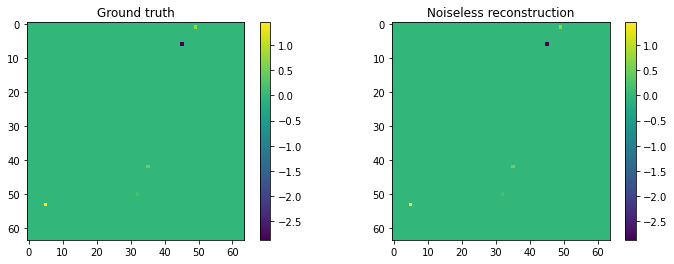

SNR: 99.53 dB


In [8]:
A_ROP2 = ROP_model2(Om_x, Om_y, a_ij, N)
y_ROP = A_ROP2@f_flat
x_ROP = bpalg(A_ROP2, y_ROP).reshape((N,N))

show_rec2D(f, x_ROP, objective=None, show_Fourier=False)

## Noisy case

Solution found after 300 iterations:
    objective function f(sol) = 5.855846e+00
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 1.428789e-02
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 9.604542e-04
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 1.515317e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.725407e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.723762e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.704423e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.692067e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.697538e-03
    stopping criterion

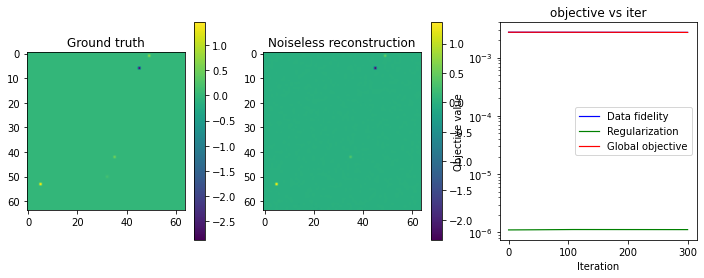

SNR: 14.00 dB


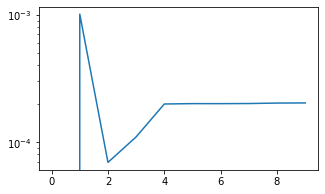

In [9]:
sig = 1e-2
noise = sig*np.random.randn(M)

y_noisy = g(f) + noise

f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop, tight=True)

f_hat = np.zeros(f.shape)
lambs = np.zeros(bigit)
objectives = np.zeros(bigit)
lamb = 1
i=1
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat
    f1 = functions.norm_l1(lambda_=lamb)
    ret = solvers.solve([f1, f2], x0, solver, rtol=1e-9, maxit=maxit) #, verbosity='NONE')
    f_hat = ret['sol']
    lamb *= epsilon/np.linalg.norm(g(ret['sol'])-y)
    lambs[i] = lamb
    objectives[i] = np.sum(np.array(ret['objective'])[-1,:])
    i+=1

show_rec2D(f, ret['sol'], objective=ret['objective'], show_Fourier=False)

plt.figure(figsize=(5,3))
plt.plot(lambs, linewidth=1.5)
plt.yscale('log')
plt.show()

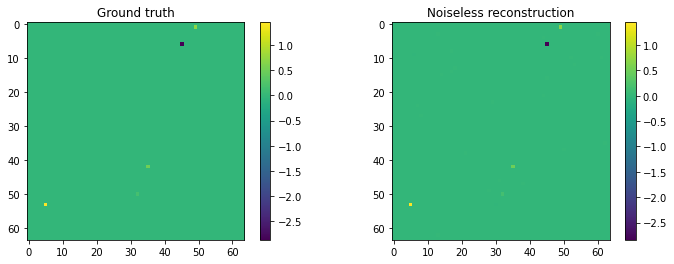

SNR: 31.09 dB


In [10]:
x_noisy = bpdnalg(A_ROP2, y_noisy,1e-8).reshape((N,N)).T
# x_corr_lasso = lasso(A_corr2_r, y_corr_r, tau=K)

show_rec2D(f, x_noisy, objective=None)

# # print('SNR: {:.2f} dB'.format(snr(f, x_corr2)) )
# # print('SNR: {:.2f} dB'.format(snr(f, x_corr_lasso)) )